# Data Cleaning and preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
df = pd.read_csv("/content/Workforce_Engagement.csv")

## Data Inspection

In [ ]:
print("--- Initial Data Inspection ---")
print("First 5 rows of the dataset:")
print(df.head())
print("Dataset Info:")
df.info()
print("Summary Statistics:")
print(df.describe())

--- Initial Data Inspection ---
First 5 rows of the dataset:
   employee_id  absence_reason_code  absence_month  weekday_code  \
0           11                   26              7             3   
1           36                    0              7             3   
2            3                   23              7             4   
3            7                    7              7             5   
4           11                   23              7             5   

   season_indicator  commute_cost  commute_distance  years_at_company  \
0                 1           289                36                13   
1                 1           118                13                18   
2                 1           179                51                18   
3                 1           279                 5                14   
4                 1           289                36                13   

   employee_age  daily_workload  ...  Unnamed: 32  Unnamed: 33  Unnamed: 34  \
0           

## Handling missing values

In [ ]:
print("--- Handling Missing Values ---")
missing_before = df.isnull().sum().sum()
print(f"Total missing values before handling: {missing_before}")

--- Handling Missing Values ---
Total missing values before handling: 15540


In [ ]:
# Drop empty columns
df = df.dropna(axis=1, how='all')

In [ ]:
print("--- Handling Missing Values ---")
missing_before = df.isnull().sum().sum()
print(f"Total missing values before handling: {missing_before}")

--- Handling Missing Values ---
Total missing values before handling: 0


## Handling duplicate values

In [ ]:
print("--- Handling Duplicates ---")
duplicates_before = df.duplicated().sum()
print(f"Number of duplicate rows before handling: {duplicates_before}")

--- Handling Duplicates ---
Number of duplicate rows before handling: 34


In [ ]:
df = df.drop_duplicates()

In [ ]:
print("--- Handling Duplicates ---")
duplicates_before = df.duplicated().sum()
print(f"Number of duplicate rows before handling: {duplicates_before}")

--- Handling Duplicates ---
Number of duplicate rows before handling: 0


## Outliers

In [ ]:
import pandas as pd

def detect_outliers_iqr(df):
    outlier_indices = {}
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Find outliers
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_indices[col] = outliers.index.tolist()

    return outlier_indices


In [ ]:
outliers_found = detect_outliers_iqr(df)
for col, indices in outliers_found.items():
    print(f"{col}: {len(indices)} outliers")

employee_id: 0 outliers
absence_reason_code: 0 outliers
absence_month: 0 outliers
weekday_code: 0 outliers
season_indicator: 0 outliers
commute_cost: 3 outliers
commute_distance: 0 outliers
years_at_company: 5 outliers
employee_age: 8 outliers
daily_workload: 32 outliers
performance_target: 19 outliers
disciplinary_action: 40 outliers
education_level: 124 outliers
dependents: 0 outliers
alcohol_consumption: 0 outliers
tobacco_use: 54 outliers
pet_count: 45 outliers
body_weight_kg: 0 outliers
body_height_cm: 119 outliers
bmi_score: 0 outliers
absence_duration_hours: 44 outliers


In [ ]:
import numpy as np

def cap_outliers_iqr(df):
    """
    Caps outliers in numerical columns using the IQR method.

    Parameters:
    df (pd.DataFrame): Input DataFrame

    Returns:
    pd.DataFrame: DataFrame with capped outliers
    """
    df_out = df.copy()
    numeric_cols = df_out.select_dtypes(include=['int64', 'float64']).columns

    for col in numeric_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Apply capping
        df_out[col] = np.where(df_out[col] < lower_bound, lower_bound,
                               np.where(df_out[col] > upper_bound, upper_bound, df_out[col]))

    return df_out


In [ ]:
# Call the function on your DataFrame
df_capped = cap_outliers_iqr(df)


In [ ]:
outliers_found = detect_outliers_iqr(df_capped)
for col, indices in outliers_found.items():
    print(f"{col}: {len(indices)} outliers")


employee_id: 0 outliers
absence_reason_code: 0 outliers
absence_month: 0 outliers
weekday_code: 0 outliers
season_indicator: 0 outliers
commute_cost: 0 outliers
commute_distance: 0 outliers
years_at_company: 0 outliers
employee_age: 0 outliers
daily_workload: 0 outliers
performance_target: 0 outliers
disciplinary_action: 0 outliers
education_level: 0 outliers
dependents: 0 outliers
alcohol_consumption: 0 outliers
tobacco_use: 0 outliers
pet_count: 0 outliers
body_weight_kg: 0 outliers
body_height_cm: 0 outliers
bmi_score: 0 outliers
absence_duration_hours: 0 outliers


## Handling categorical values

In [ ]:
cat_cols_explicit = df_capped.select_dtypes(include=["object", "category"]).columns.tolist()

# 2. Numeric columns with low number of unique values (potential categories)
cat_cols_numeric = [col for col in df_capped.columns
                    if df_capped[col].nunique() < 7 and df_capped[col].dtype in ["int64", "float64"]]

print("Explicit categorical columns:", cat_cols_explicit)
print("Numeric columns likely categorical:", cat_cols_numeric)


Explicit categorical columns: []
Numeric columns likely categorical: ['weekday_code', 'season_indicator', 'disciplinary_action', 'education_level', 'dependents', 'alcohol_consumption', 'tobacco_use', 'pet_count']


## Data Transformation

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Separate features and target
X = df_capped.drop('absence_duration_hours', axis=1)  # Replace with your actual target column name
y = df_capped['absence_duration_hours']

# Step 2: Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


# Exploratory data analysis

In [ ]:
df_capped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 706 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   employee_id             706 non-null    float64
 1   absence_reason_code     706 non-null    float64
 2   absence_month           706 non-null    float64
 3   weekday_code            706 non-null    float64
 4   season_indicator        706 non-null    float64
 5   commute_cost            706 non-null    float64
 6   commute_distance        706 non-null    float64
 7   years_at_company        706 non-null    float64
 8   employee_age            706 non-null    float64
 9   daily_workload          706 non-null    float64
 10  performance_target      706 non-null    float64
 11  disciplinary_action     706 non-null    float64
 12  education_level         706 non-null    float64
 13  dependents              706 non-null    float64
 14  alcohol_consumption     706 non-null    float64

In [ ]:
pd.set_option("display.float_format", "{:.2f}".format)
df_capped.describe()

,employee_id,absence_reason_code,absence_month,weekday_code,season_indicator,commute_cost,commute_distance,years_at_company,employee_age,daily_workload,...,disciplinary_action,education_level,dependents,alcohol_consumption,tobacco_use,pet_count,body_weight_kg,body_height_cm,bmi_score,absence_duration_hours
count,706.00,706.00,706.00,706.00,706.00,706.00,706.00,706.00,706.00,706.00,...,706.00,706.00,706.00,706.00,706.00,706.00,706.00,706.00,706.00,706.00
mean,18.19,18.88,6.41,3.89,2.55,222.95,29.30,12.48,36.43,271.67,...,0.00,1.00,1.06,0.57,0.00,0.62,79.01,171.05,26.64,5.18
std,10.93,8.48,3.40,1.43,1.12,67.23,14.71,4.31,6.41,38.36,...,0.00,0.00,1.10,0.50,0.00,0.86,12.86,3.00,4.25,4.56
min,1.00,0.00,0.00,2.00,1.00,118.00,5.00,1.00,27.00,205.92,...,0.00,1.00,0.00,0.00,0.00,0.00,56.00,164.50,19.00,0.00
25%,10.00,13.00,3.00,3.00,2.00,179.00,16.00,9.00,31.00,244.39,...,0.00,1.00,0.00,0.00,0.00,0.00,69.00,169.00,24.00,2.00
50%,18.00,23.00,6.00,4.00,3.00,225.00,26.00,13.00,37.00,264.60,...,0.00,1.00,1.00,1.00,0.00,0.00,80.00,171.00,25.00,3.00
75%,28.00,26.00,9.75,5.00,4.00,260.00,49.00,16.00,40.00,294.22,...,0.00,1.00,2.00,1.00,0.00,1.00,89.00,172.00,31.00,8.00
max,36.00,28.00,12.00,6.00,4.00,381.50,52.00,26.50,53.50,368.96,...,0.00,1.00,4.00,1.00,0.00,2.50,108.00,176.50,38.00,17.00


In [ ]:
for column in df_capped.columns:
    print(f"===============Column: {column}==============")
    print(f"Number of unique values: {df_capped[column].nunique()}")
    print(f"Max: {df_capped[column].max()}")
    print(f"Min: {df_capped[column].min()}")

===============Column: employee_id==============
Number of unique values: 36
Max: 36.0
Min: 1.0
===============Column: absence_reason_code==============
Number of unique values: 28
Max: 28.0
Min: 0.0
===============Column: absence_month==============
Number of unique values: 13
Max: 12.0
Min: 0.0
===============Column: weekday_code==============
Number of unique values: 5
Max: 6.0
Min: 2.0
===============Column: season_indicator==============
Number of unique values: 4
Max: 4.0
Min: 1.0
===============Column: commute_cost==============
Number of unique values: 24
Max: 381.5
Min: 118.0
===============Column: commute_distance==============
Number of unique values: 25
Max: 52.0
Min: 5.0
===============Column: years_at_company==============
Number of unique values: 18
Max: 26.5
Min: 1.0
===============Column: employee_age==============
Number of unique values: 22
Max: 53.5
Min: 27.0
===============Column: daily_workload==============
Number of unique values: 37
Max: 368.962
Min: 205.917
==

In [ ]:
df_capped.columns

Index(['employee_id', 'absence_reason_code', 'absence_month', 'weekday_code',
       'season_indicator', 'commute_cost', 'commute_distance',
       'years_at_company', 'employee_age', 'daily_workload',
       'performance_target', 'disciplinary_action', 'education_level',
       'dependents', 'alcohol_consumption', 'tobacco_use', 'pet_count',
       'body_weight_kg', 'body_height_cm', 'bmi_score',
       'absence_duration_hours'],
      dtype='object')

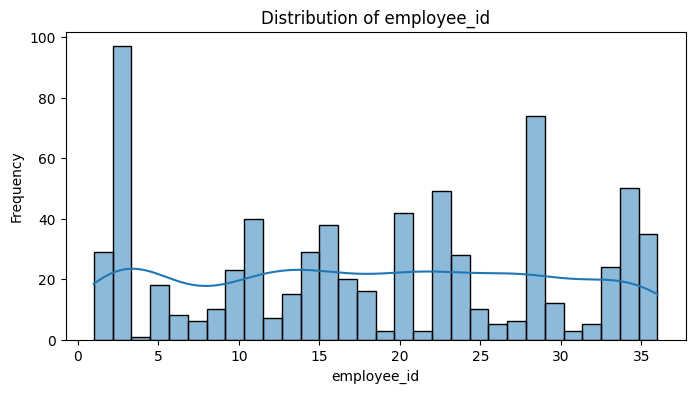

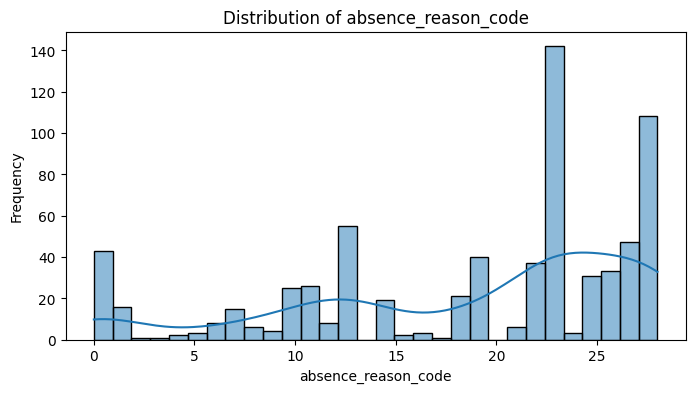

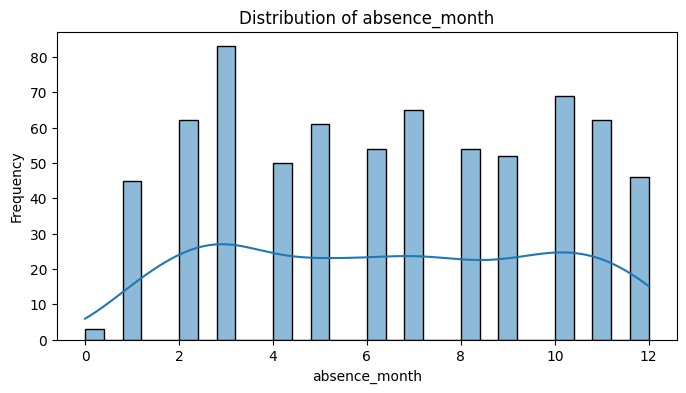

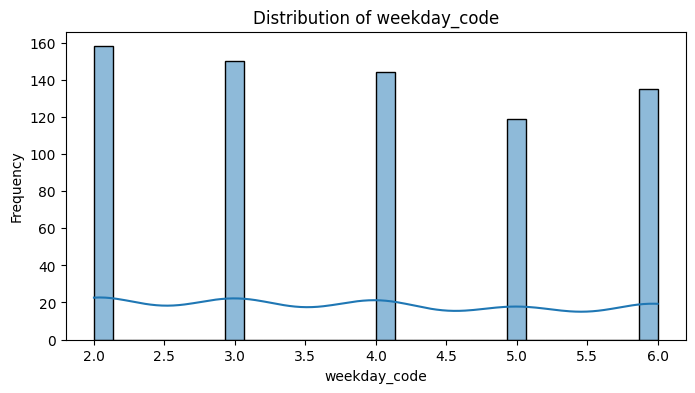

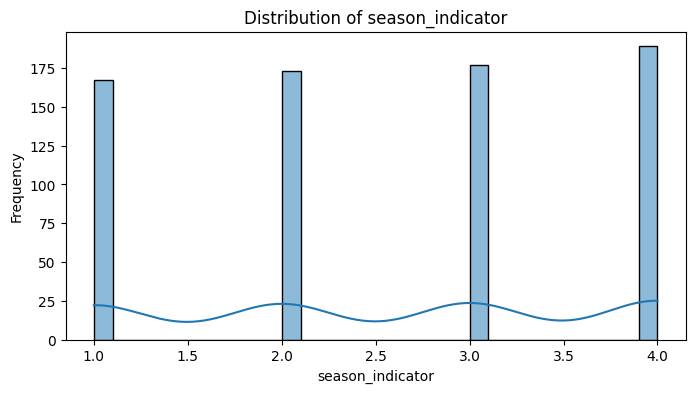

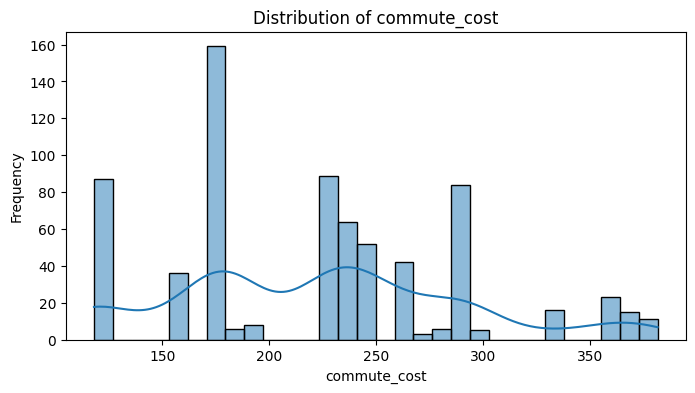

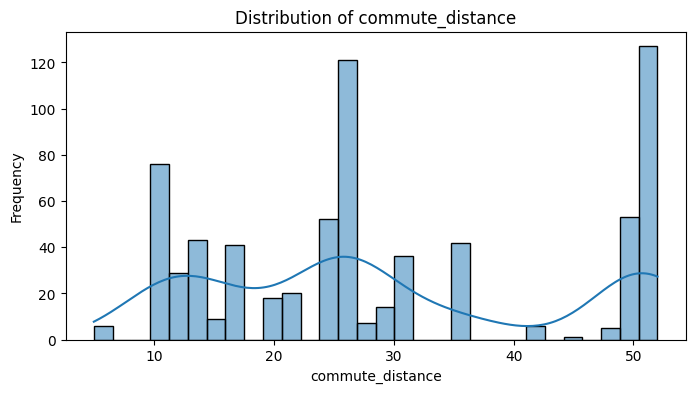

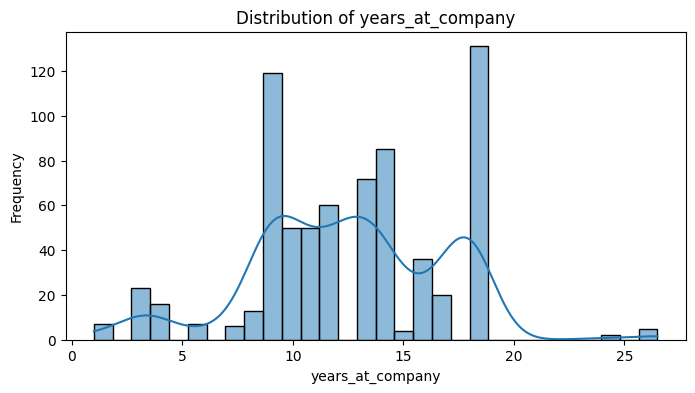

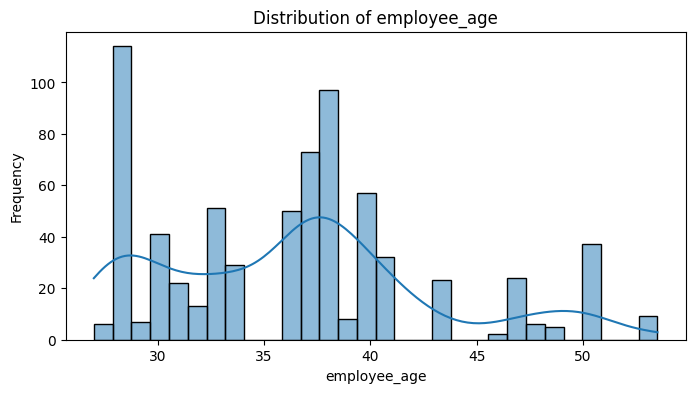

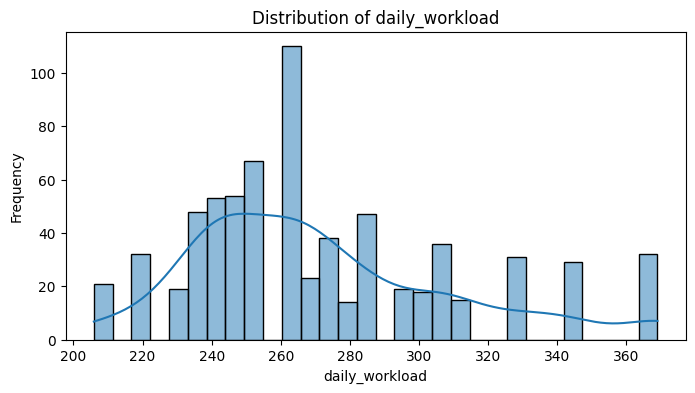

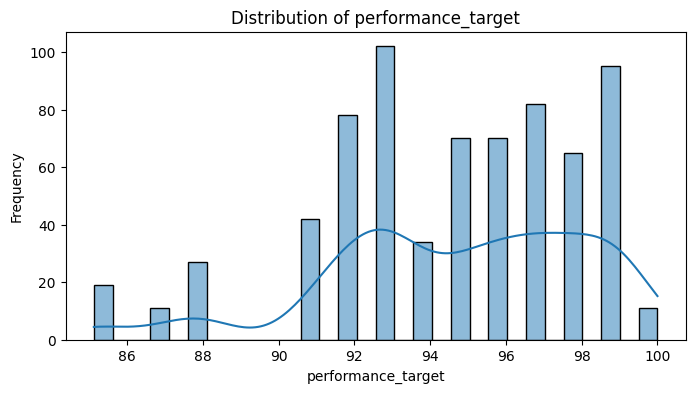

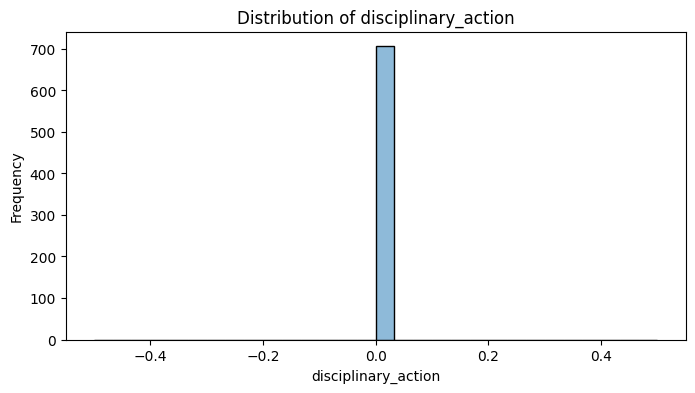

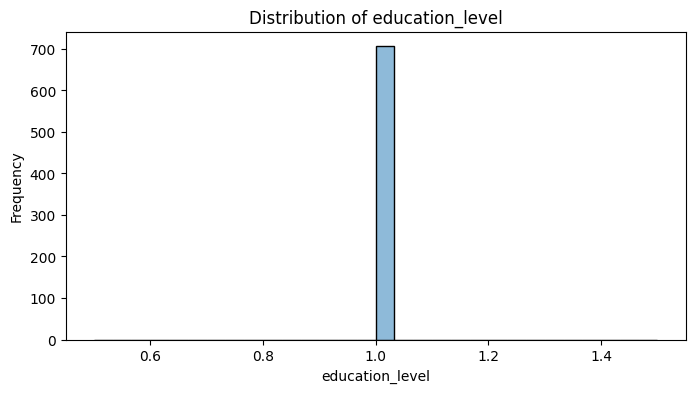

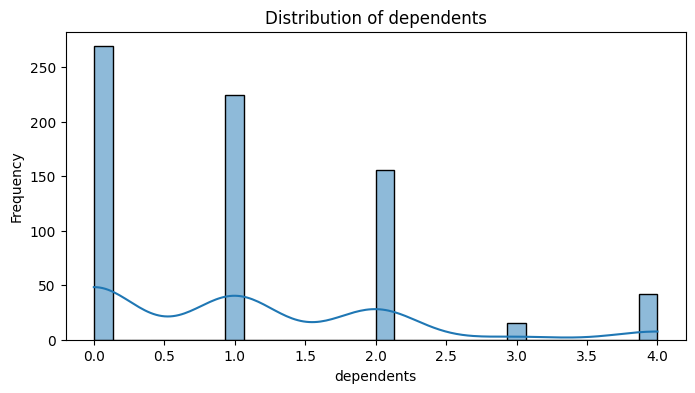

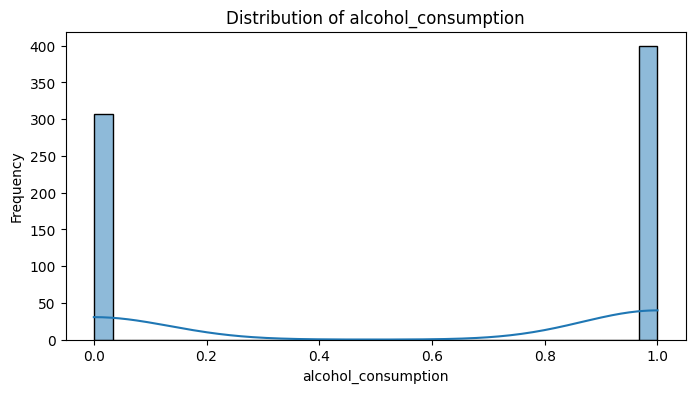

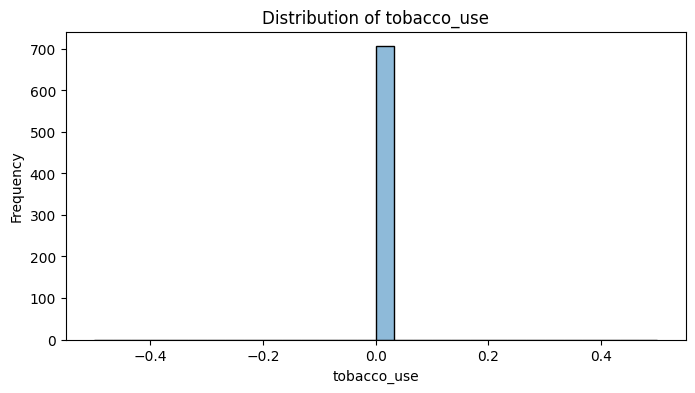

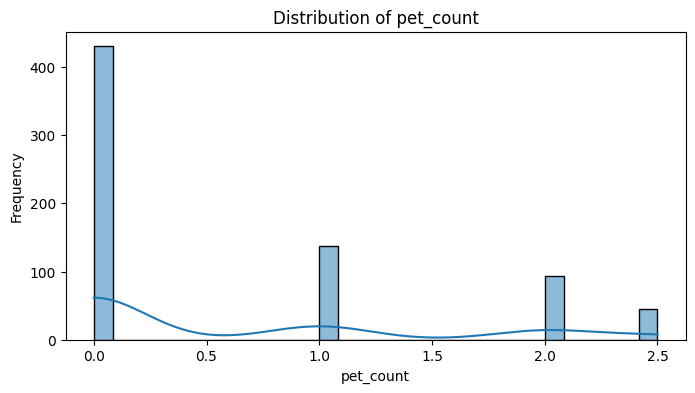

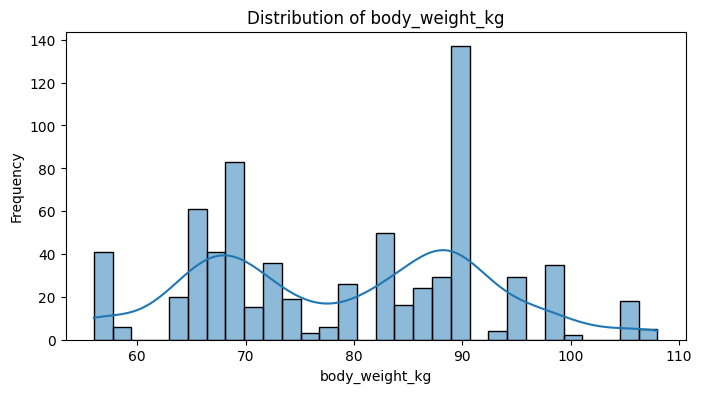

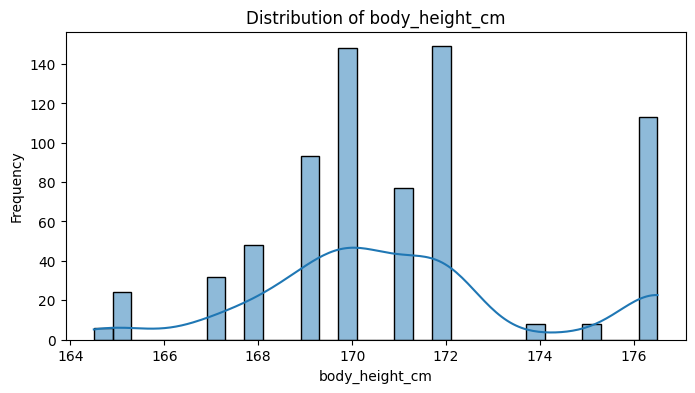

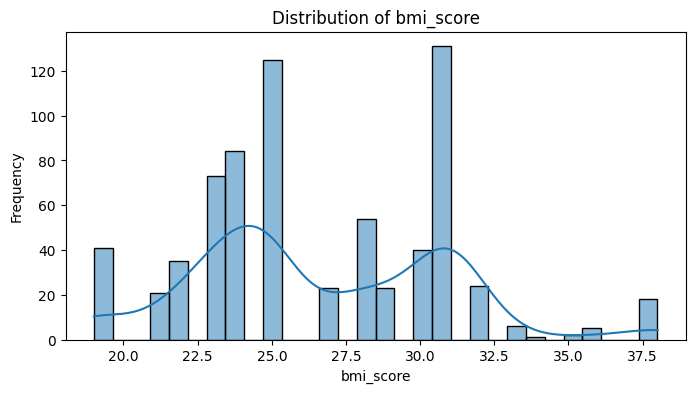

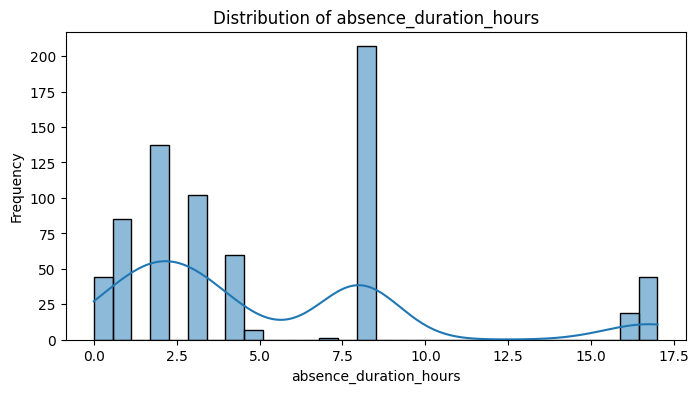

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through all columns and plot distribution
for col in df_capped.columns:
    plt.figure(figsize=(8,4))
    if df_capped[col].dtype in ["int64", "float64"]:
        # Numeric columns
        sns.histplot(df_capped[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    else:
        # Categorical columns
        sns.countplot(x=df_capped[col])
        plt.title(f"Count Plot of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
    plt.show()


# Feature Selection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

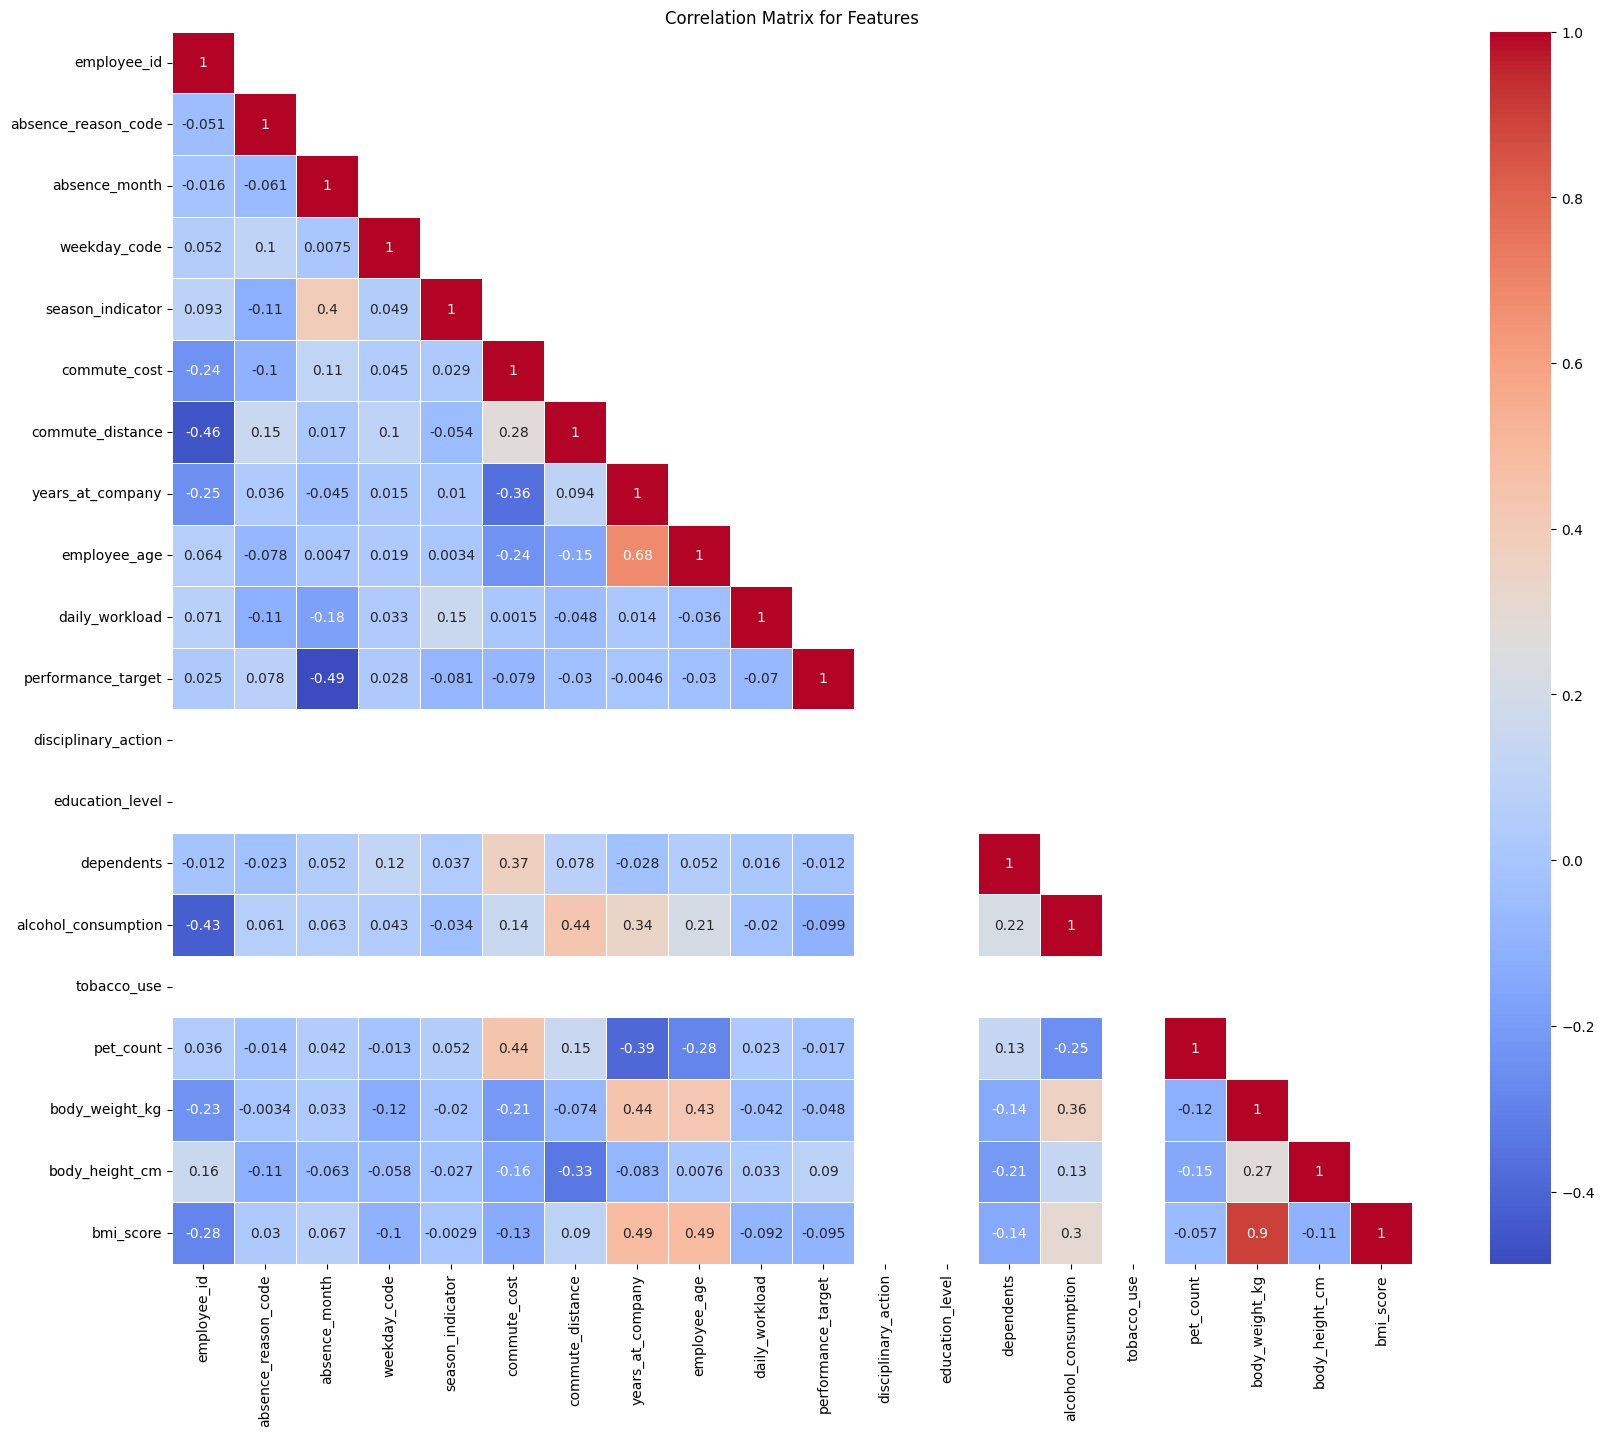

In [ ]:
def display_correlation_matrix(corr_matrix):
    plt.figure(figsize=(20, 16))  # Adjust the size as needed
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5,mask=np.triu(corr_matrix, k=1))
    plt.title('Correlation Matrix for Features')
    plt.show()

corr_matrix = X.corr()
display_correlation_matrix(corr_matrix)

In [ ]:
corr_matrix = X.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Extract the upper triangle values as a series
upper_tri_series = corr_matrix.where(mask).stack()
# Exclude values of 1
upper_tri_series = upper_tri_series[upper_tri_series != 1]
print("Top 10 positive correlations:")
print(upper_tri_series.abs().sort_values(ascending=False).head(10))
print("\nTop 10 negative correlations:")
print(upper_tri_series.abs().sort_values(ascending=False).tail(10).sort_values(ascending=True))

Top 10 positive correlations:
body_weight_kg    bmi_score             0.90
years_at_company  employee_age          0.68
                  bmi_score             0.49
absence_month     performance_target    0.49
employee_age      bmi_score             0.49
employee_id       commute_distance      0.46
years_at_company  body_weight_kg        0.44
commute_cost      pet_count             0.44
commute_distance  alcohol_consumption   0.44
employee_id       alcohol_consumption   0.43
dtype: float64

Top 10 negative correlations:
commute_cost         daily_workload       0.00
season_indicator     bmi_score            0.00
                     employee_age         0.00
absence_reason_code  body_weight_kg       0.00
years_at_company     performance_target   0.00
absence_month        employee_age         0.00
                     weekday_code         0.01
employee_age         body_height_cm       0.01
season_indicator     years_at_company     0.01
employee_id          dependents           0.01
dtyp

In [ ]:
features_to_drop = ['body_height_cm','body_weight_kg']
df_capped = df_capped.drop(columns=features_to_drop)

In [ ]:
df_capped = df_capped.drop(columns=['pet_count'])

In [ ]:
# Categorize target
def categorize_absence(x):
    if x <= 8:
        return "Low"
    elif 8 < x <= 16:
        return "Medium"
    else:
        return "High"
df_capped['Absence_category'] = df_capped["absence_duration_hours"].apply(categorize_absence)




In [ ]:
df_capped.head()

,employee_id,absence_reason_code,absence_month,weekday_code,season_indicator,commute_cost,commute_distance,years_at_company,employee_age,daily_workload,performance_target,disciplinary_action,education_level,dependents,alcohol_consumption,tobacco_use,bmi_score,absence_duration_hours,Absence_category
0,11.00,26.00,7.00,3.00,1.00,289.00,36.00,13.00,33.00,239.55,97.00,0.00,1.00,2.00,1.00,0.00,30.00,4.00,Low
1,36.00,0.00,7.00,3.00,1.00,118.00,13.00,18.00,50.00,239.55,97.00,0.00,1.00,1.00,1.00,0.00,31.00,0.00,Low
2,3.00,23.00,7.00,4.00,1.00,179.00,51.00,18.00,38.00,239.55,97.00,0.00,1.00,0.00,1.00,0.00,31.00,2.00,Low
3,7.00,7.00,7.00,5.00,1.00,279.00,5.00,14.00,39.00,239.55,97.00,0.00,1.00,2.00,1.00,0.00,24.00,4.00,Low
4,11.00,23.00,7.00,5.00,1.00,289.00,36.00,13.00,33.00,239.55,97.00,0.00,1.00,2.00,1.00,0.00,30.00,2.00,Low


In [ ]:
X = df_capped.drop("Absence_category", axis=1)
y = df_capped["Absence_category"]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
le = LabelEncoder()

# Fit and transform target
y_encoded = le.fit_transform(y)

# Check mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:", label_mapping)



Label Encoding Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


# Model Selection

## Cross Validation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split dataset (assuming you already have X_ready, y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [ ]:
models = [
    LogisticRegression(max_iter=1000),
    RidgeClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    SVC(),
    KNeighborsClassifier()
]

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

def compare_models_cross_validation(X, y, models):
    print("=== Cross Validation Comparison ===\n")
    for model in models:
        cv_score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
        mean_accuracy = round(np.mean(cv_score) * 100, 2)
        print(f"{model.__class__.__name__}:")
        print(f"  Fold Accuracies: {cv_score}")
        print(f"  Mean Accuracy: {mean_accuracy}%")
        print("---------------------------------------------------------------")


In [ ]:
compare_models_cross_validation(X_train, y_train, models)

=== Cross Validation Comparison ===



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression:
  Fold Accuracies: [0.97345133 0.98230088 0.98230088 0.97345133 1.        ]
  Mean Accuracy: 98.23%
---------------------------------------------------------------
RidgeClassifier:
  Fold Accuracies: [0.97345133 0.96460177 0.97345133 0.96460177 0.97321429]
  Mean Accuracy: 96.99%
---------------------------------------------------------------
DecisionTreeClassifier:
  Fold Accuracies: [1. 1. 1. 1. 1.]
  Mean Accuracy: 100.0%
---------------------------------------------------------------
RandomForestClassifier:
  Fold Accuracies: [1.         0.98230088 0.98230088 0.99115044 0.99107143]
  Mean Accuracy: 98.94%
---------------------------------------------------------------
GradientBoostingClassifier:
  Fold Accuracies: [1. 1. 1. 1. 1.]
  Mean Accuracy: 100.0%
---------------------------------------------------------------
AdaBoostClassifier:
  Fold Accuracies: [1. 1. 1. 1. 1.]
  Mean Accuracy: 100.0%
---------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier:
  Fold Accuracies: [1. 1. 1. 1. 1.]
  Mean Accuracy: 100.0%
---------------------------------------------------------------
SVC:
  Fold Accuracies: [0.91150442 0.91150442 0.91150442 0.91150442 0.91071429]
  Mean Accuracy: 91.13%
---------------------------------------------------------------
KNeighborsClassifier:
  Fold Accuracies: [0.92035398 0.91150442 0.91150442 0.90265487 0.91071429]
  Mean Accuracy: 91.13%
---------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Hyperparameter Tuning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


models_list = [
    LogisticRegression(max_iter=1000),
    RidgeClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    SVC(),
    KNeighborsClassifier()
]


model_hyperparameters = {
    'logistic_regression_hyperparameters': {
        'fit_intercept': [True, False],
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'saga']
    },
    'ridge_classifier_hyperparameters': {
        'alpha': [0.1, 1, 10, 100]
    },
    'decision_tree_hyperparameters': {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'random_forest_hyperparameters': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'gradient_boosting_hyperparameters': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'ada_boost_hyperparameters': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'xgboost_hyperparameters': {
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'svm_hyperparameters': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'knn_hyperparameters': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}


X_small, X_test, y_small, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_small_scaled = scaler.fit_transform(X_small)
X_test_scaled = scaler.transform(X_test)


def OptimizedModelSelection(list_of_models, hyperparameters_dictionary, n_iter=20, cv=5, random_state=42):
    results = []
    model_keys = list(hyperparameters_dictionary.keys())

    for model, key in zip(list_of_models, model_keys):
        params = hyperparameters_dictionary[key]
        model_name = model.__class__.__name__
        print(f"\n🔍 Running {model_name} ...")

        if model_name in ["LogisticRegression", "SVC", "KNeighborsClassifier"]:
            X_fit = X_small_scaled
        else:
            X_fit = X_small


        total_combinations = np.prod([len(v) for v in params.values()])
        n_iter_eff = min(n_iter, total_combinations)

        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=n_iter_eff,
            cv=cv,
            n_jobs=-1,
            random_state=random_state,
            scoring='accuracy',
            verbose=1
        )

        search.fit(X_fit, y_small)

        results.append({
            'model': model_name,
            'best_score': round(search.best_score_, 4),
            'best_params': search.best_params_
        })

    return pd.DataFrame(results)


results_df = OptimizedModelSelection(models_list, model_hyperparameters, n_iter=15, cv=5)

print("\n✅ Final Results:")
print(results_df)



🔍 Running LogisticRegression ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🔍 Running RidgeClassifier ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

🔍 Running DecisionTreeClassifier ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

🔍 Running RandomForestClassifier ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

🔍 Running GradientBoostingClassifier ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🔍 Running AdaBoostClassifier ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

🔍 Running XGBClassifier ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:20:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 Running SVC ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

🔍 Running KNeighborsClassifier ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✅ Final Results:
                        model  best_score  \
0          LogisticRegression        0.98   
1             RidgeClassifier        0.97   
2      DecisionTreeClassifier        1.00   
3      RandomForestClassifier        0.99   
4  GradientBoostingClassifier        1.00   
5          AdaBoostClassifier        1.00   
6               XGBClassifier        1.00   
7                         SVC        1.00   
8        KNeighborsClassifier        0.94   

                                         best_params  
0  {'solver': 'lbfgs', 'fit_intercept': True, 'C'...  
1                                     {'alpha': 0.1}  
2  {'min_samples_split': 10, 'min_samples_leaf': ...  
3  {'n_estimators': 100, 'min_samples_split': 5, ...  
4  {'n_estimators': 100, 'max_depth': 3, 'learnin...  
5         {'n_estimators

### Cross Validation and Hyperparameter Tuning Results

---

####  Cross Validation Summary

| Model                     | Mean Accuracy (%) |
|----------------------------|------------------:|
| Logistic Regression        | 98.23 |
| Ridge Classifier           | 96.99 |
| Decision Tree              | 100.00 |
| Random Forest              | 98.94 |
| Gradient Boosting          | 100.00 |
| AdaBoost                   | 100.00 |
| XGBoost                    | 100.00 |
| SVC                        | 91.13 |
| KNN                        | 91.13 |

---

####  Final Optimized Model Results

| Model                     | Best Score | Best Parameters |
|----------------------------|------------|-----------------|
| Logistic Regression        | 0.98 | `{'solver': 'lbfgs', 'fit_intercept': True, 'C': 1.0}` |
| Ridge Classifier           | 0.97 | `{'alpha': 0.1}` |
| Decision Tree              | 1.00 | `{'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': None}` |
| Random Forest              | 0.99 | `{'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None}` |
| Gradient Boosting          | 1.00 | `{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}` |
| AdaBoost                   | 1.00 | `{'n_estimators': 50, 'learning_rate': 0.1}` |
| XGBoost                    | 1.00 | `{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1}` |
| SVC                        | 1.00 | `{'kernel': 'linear', 'gamma': 'auto', 'C': 10}` |
| KNeighborsClassifier        | 0.94 | `{'weights': 'distance', 'n_neighbors': 5, 'metric': 'minkowski'}` |




# Train, Test and Validate split

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split into 60% train and 40% temp (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split the 40% temp into 20% test and 20% validation
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Check the resulting shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)


Training set shape: (423, 18) (423,)
Testing set shape: (141, 18) (141,)
Validation set shape: (142, 18) (142,)


# Model Building

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# --- Step 1: Initialize the Decision Tree Classifier ---
clf = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=5, max_depth=None)

# Train the model
clf.fit(X_train, y_train)

# --- Step 2: Predictions ---
y_pred_test = clf.predict(X_test)
y_pred_validate = clf.predict(X_val)

# --- Step 3: Evaluation on Testing Data ---
print("\n=== Testing Data Evaluation (Decision Tree) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_test, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_test, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# --- Step 4: Evaluation on Validation Data ---
print("\n=== Validation Data Evaluation (Decision Tree) ===")
print("Accuracy:", accuracy_score(y_val, y_pred_validate))
print("Precision:", precision_score(y_val, y_pred_validate, average='weighted'))
print("Recall:", recall_score(y_val, y_pred_validate, average='weighted'))
print("F1 Score:", f1_score(y_val, y_pred_validate, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_validate))
print("\nClassification Report:\n", classification_report(y_val, y_pred_validate))



=== Testing Data Evaluation (Decision Tree) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[  9   0   0]
 [  0 129   0]
 [  0   0   3]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00         3

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141


=== Validation Data Evaluation (Decision Tree) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[  9   0   0]
 [  0 129   0]
 [  0   0   4]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00         4

    accu

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1
)

# Train the model
clf.fit(X_train, y_train)

# --- Step 2: Predictions ---
y_pred_test = clf.predict(X_test)
y_pred_validate = clf.predict(X_val)

# --- Step 3: Evaluation on Testing Data ---
print("\n=== Testing Data Evaluation (Gradient Boosting) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_test, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_test, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# --- Step 4: Evaluation on Validation Data ---
print("\n=== Validation Data Evaluation (Gradient Boosting) ===")
print("Accuracy:", accuracy_score(y_val, y_pred_validate))
print("Precision:", precision_score(y_val, y_pred_validate, average='weighted'))
print("Recall:", recall_score(y_val, y_pred_validate, average='weighted'))
print("F1 Score:", f1_score(y_val, y_pred_validate, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_validate))
print("\nClassification Report:\n", classification_report(y_val, y_pred_validate))



=== Testing Data Evaluation (Gradient Boosting) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[  9   0   0]
 [  0 129   0]
 [  0   0   3]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00         3

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141


=== Validation Data Evaluation (Gradient Boosting) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[  9   0   0]
 [  0 129   0]
 [  0   0   4]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00         4



## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# --- Step 1: Initialize the AdaBoost Classifier ---
clf = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=0.1
)

# Train the model
clf.fit(X_train, y_train)

# --- Step 2: Predictions ---
y_pred_test = clf.predict(X_test)
y_pred_validate = clf.predict(X_val)

# --- Step 3: Evaluation on Testing Data ---
print("\n=== Testing Data Evaluation (AdaBoost) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_test, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_test, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# --- Step 4: Evaluation on Validation Data ---
print("\n=== Validation Data Evaluation (AdaBoost) ===")
print("Accuracy:", accuracy_score(y_val, y_pred_validate))
print("Precision:", precision_score(y_val, y_pred_validate, average='weighted'))
print("Recall:", recall_score(y_val, y_pred_validate, average='weighted'))
print("F1 Score:", f1_score(y_val, y_pred_validate, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_validate))
print("\nClassification Report:\n", classification_report(y_val, y_pred_validate))



=== Testing Data Evaluation (AdaBoost) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[  9   0   0]
 [  0 129   0]
 [  0   0   3]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00         3

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141


=== Validation Data Evaluation (AdaBoost) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[  9   0   0]
 [  0 129   0]
 [  0   0   4]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00         4

    accuracy      

## XGBoosting

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# --- Step 1: Initialize the XGBoost Classifier ---
clf = XGBClassifier(subsample= 1.0, n_estimators=100, min_child_weight=1)

# Train the model
clf.fit(X_train, y_train)

# --- Step 2: Predictions ---
y_pred_test = clf.predict(X_test)
y_pred_validate = clf.predict(X_val)

# --- Step 3: Evaluation on Testing Data ---
print("\n=== Testing Data Evaluation (XGBoost) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_test, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_test, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# --- Step 4: Evaluation on Validation Data ---
print("\n=== Validation Data Evaluation (XGBoost) ===")
print("Accuracy:", accuracy_score(y_val, y_pred_validate))
print("Precision:", precision_score(y_val, y_pred_validate, average='weighted'))
print("Recall:", recall_score(y_val, y_pred_validate, average='weighted'))
print("F1 Score:", f1_score(y_val, y_pred_validate, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_validate))
print("\nClassification Report:\n", classification_report(y_val, y_pred_validate))



=== Testing Data Evaluation (XGBoost) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[  9   0   0]
 [  0 129   0]
 [  0   0   3]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00         3

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141


=== Validation Data Evaluation (XGBoost) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[  9   0   0]
 [  0 129   0]
 [  0   0   4]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00         4

    accuracy        

# Summary

=== Model Evaluation Summary ===

Observations from Metrics:

- All four models (Decision Tree, Gradient Boosting, AdaBoost, XGBoost) achieved:
    - Accuracy = 100%
    - Precision = 1.0
    - Recall = 1.0
    - F1 Score = 1.0
- Confusion matrices show perfect predictions for all classes on both testing and validation sets.
- The dataset is relatively small (706 samples total) and may be easy to separate, which explains the perfect scores.

Practical Considerations:

Model               | Pros                                   | Cons                                     | Notes
------------------- | ------------------------------------- | --------------------------------------- | ------------------------------------------------
Decision Tree       | Simple, interpretable, fast           | Can easily overfit, especially on small datasets | Perfect on this dataset, but may fail on unseen real-world data
Gradient Boosting   | Handles overfitting better, robust    | Slower to train                          | Excellent choice for generalization
AdaBoost            | Reduces bias, robust to overfitting  | Sensitive to noisy data                  | Very reliable on small datasets
XGBoost             | State-of-the-art boosting, robust    | More complex, hyperparameter tuning needed | Most commonly used in competitions and industry

 Correct Conclusion:

- All models performed perfectly here, but the best choice in practice is an ensemble method:
    - **XGBoost (or Gradient Boosting / AdaBoost)**
- Reason:
    - Ensembles reduce overfitting compared to a single Decision Tree.
    - They generalize better to new/unseen data.
    - Widely used in industry for structured/tabular data.
- Decision Tree is not recommended as the “best” even though it shows perfect accuracy, because it may overfit and fail on slightly different data.

Summary:
- **Best model → XGBoost (or Gradient Boosting/AdaBoost)**
- **Reason → Combines multiple trees to generalize better and reduce overfitting, ensuring reliability on real-world data.**
